# Lending Club Case Study

## Introduction

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings("ignore")

## Initial Data Analysis

In [3]:
# Read the dataset and check the first five rows
df = pd.read_csv("loan.csv")
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
# Check the shape, info and types of columns of the dataframe
df.shape

(39717, 111)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [6]:
df.dtypes

id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object

## Data Handling and Cleaning

#### Missing Value Treatment

In [7]:
# Check which columns have null values
df.isnull().sum().sort_values(ascending=False)

verification_status_joint    39717
annual_inc_joint             39717
mo_sin_old_rev_tl_op         39717
mo_sin_old_il_acct           39717
bc_util                      39717
                             ...  
delinq_amnt                      0
policy_code                      0
earliest_cr_line                 0
delinq_2yrs                      0
id                               0
Length: 111, dtype: int64

In [8]:
# Drop the columns that are completely empty
df.dropna(axis = 1, how = 'all', inplace = True)
df.shape

(39717, 57)

In [9]:
# Check the number of nulls again
df.isnull().sum().sort_values(ascending=False)

next_pymnt_d                  38577
mths_since_last_record        36931
mths_since_last_delinq        25682
desc                          12942
emp_title                      2459
emp_length                     1075
pub_rec_bankruptcies            697
last_pymnt_d                     71
chargeoff_within_12_mths         56
collections_12_mths_ex_med       56
revol_util                       50
tax_liens                        39
title                            11
last_credit_pull_d                2
home_ownership                    0
int_rate                          0
out_prncp_inv                     0
total_pymnt                       0
total_pymnt_inv                   0
total_rec_prncp                   0
total_rec_int                     0
total_rec_late_fee                0
recoveries                        0
collection_recovery_fee           0
term                              0
last_pymnt_amnt                   0
initial_list_status               0
funded_amnt_inv             

In [10]:
# Dropping the columns with more than 20% missing values
df = df.dropna(thresh=int(0.8*len(df)), axis=1)
df.shape

(39717, 53)

#### Check and remove columns with single values

In [11]:
cols_to_remove = [col for col in df.columns if df[col].nunique() == 1]

df.drop(columns=cols_to_remove, inplace=True)
df.shape

(39717, 44)

#### Check for duplicated rows

In [12]:
df.duplicated().sum()

0

#### Dropping columns irrelevant to our analysis


In [13]:
# The below columns don't provide any necessary data to predict loan default. In other
# words, these columns don't act as driver variables.
columns_to_drop = [
 'collection_recovery_fee', # Post charge off fee. Not relevant
 'emp_title', # Employment title. Doesn't help analysis
 'funded_amnt',
 'funded_amnt_inv',
 'inq_last_6mths', # Number of inquiries last 6 months. Doesn't help analysis
 'last_credit_pull_d', 
 'last_pymnt_amnt',
 'last_pymnt_d', 
 'member_id', # Not required
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'pub_rec',
 'recoveries', 
 'revol_bal',
 'revol_util',
 'title', # User entered values
 'total_pymnt', # This and below aren't strong enough driver variables for credit defaults
 'total_pymnt_inv', 
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp', 
 'url', # Redundant as the url is just https://lendingclub.com/browse/loanDetail.action? followed by loan_id
 'zip_code' # Too granular. Can use the address field instead. 
]

df.drop(columns=columns_to_drop, inplace=True)
df.shape

(39717, 20)

#### Dropping "Current" loan_status rows

In [14]:
# We are dropping all the rows that have the 'Current' loan status as these entries don't give us any
# information that suggests whether a loan will default or not
df = df[df.loan_status != 'Current']
df.shape

(38577, 20)

#### Data conversions


In [15]:
# Converting "term" to an integer
df.term = df.term.map(lambda x: int(x.rstrip(" months")))
df.term

0        36
1        60
2        36
3        36
5        36
         ..
39712    36
39713    36
39714    36
39715    36
39716    36
Name: term, Length: 38577, dtype: int64

In [16]:
# Converting issue_d and earliest_cr_line to datetime
df.issue_d = pd.to_datetime(df.issue_d, format="%b-%y")
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format="%b-%y")

In [17]:
def emp_length_to_int(x):
    if pd.isna(x):
        return np.nan
    elif x == '< 1 year':
        return 0
    elif x == '10+ years':
        return 10
    else:
        return int(x.split()[0])

# Use the map function to replace values in the 'emp_length' column
df.emp_length = df.emp_length.apply(emp_length_to_int)

In [18]:
# Convert int_rate to a float
df.int_rate = df.int_rate.map(lambda x: float(x.rstrip("%")))

In [19]:
# Standardize home_ownership such that NONE ---> OTHER
df.home_ownership.replace("NONE", "OTHER", inplace=True)
df.home_ownership.value_counts()

home_ownership
RENT        18480
MORTGAGE    17021
OWN          2975
OTHER         101
Name: count, dtype: int64

In [20]:
# Standardize verification_status such that "Source Verified" ---> "Verified"
df.verification_status.replace("Source Verified", "Verified", inplace=True)

#### Imputing missing values

In [21]:
# Imputing missing values for pub_rec_bankruptcies
df.pub_rec_bankruptcies.fillna(0, inplace=True)

In [22]:
# Inputing missing values for emp_length. We will impute 70% of the data using the mode
# and 30% of the data using random sampling.
mode_emp_length = df.emp_length.mode()[0]
unique_emp_lengths = df.emp_length.dropna().unique()

def impute_emp_length(x):
    if pd.isna(x):
        # 70% chance of using the mode, 30% chance of random sampling
        if np.random.random() < 0.7:
            return mode_emp_length
        else:
            return np.random.choice(unique_emp_lengths)
    return x

# Step 5: Apply the imputation
df.emp_length = df.emp_length.apply(impute_emp_length)

#### Handling Outliers

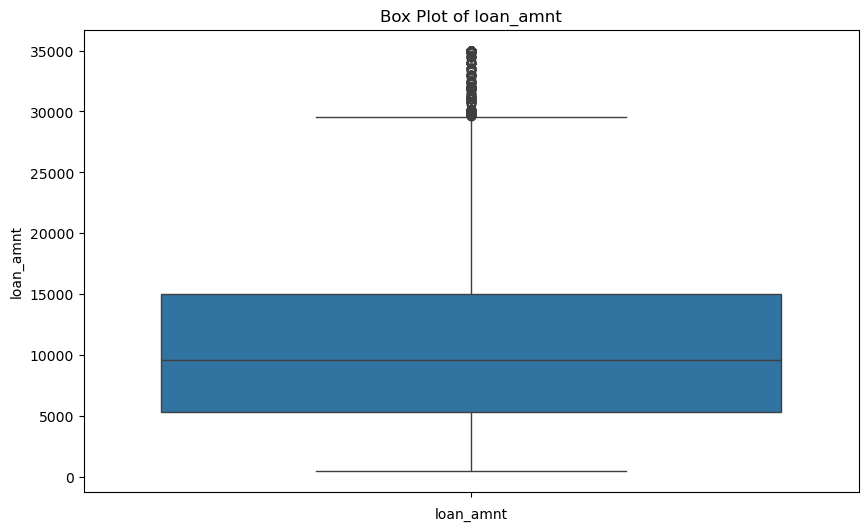

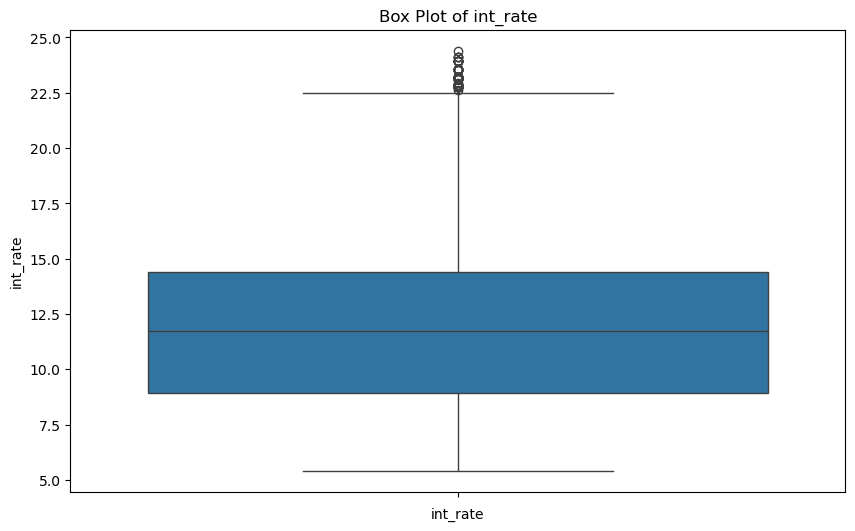

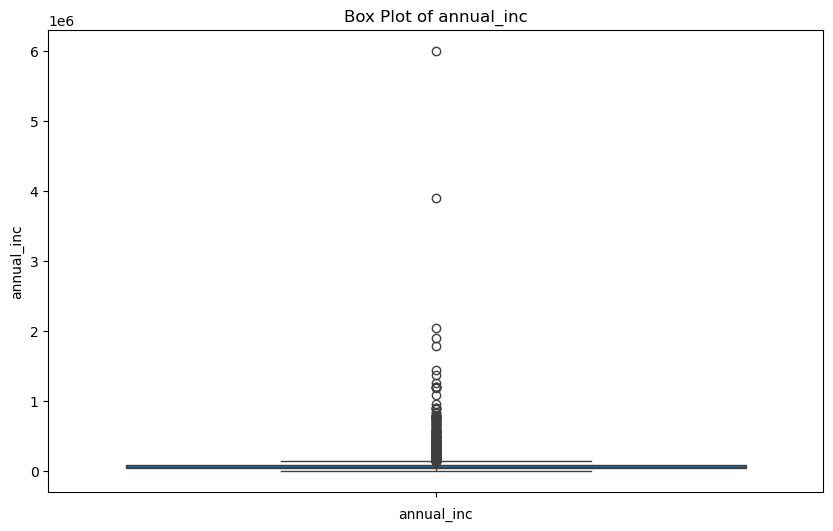

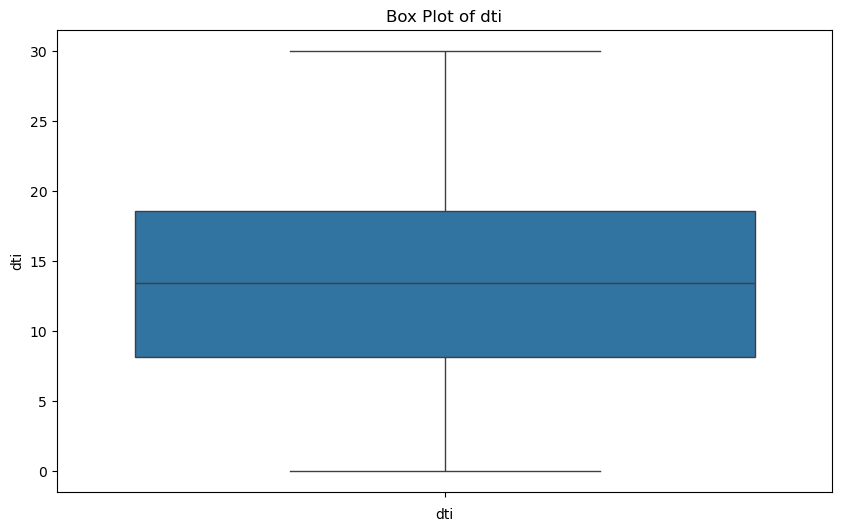

In [23]:
# Checking for outliers in loan_amount, int_rate, annual_inc, dti
cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']

# Box plots for numerical variables
for var in cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(df[var])
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.show()

plt.show()


Clearly, there are outliers in annual_inc. Let's treat these using the IQR method

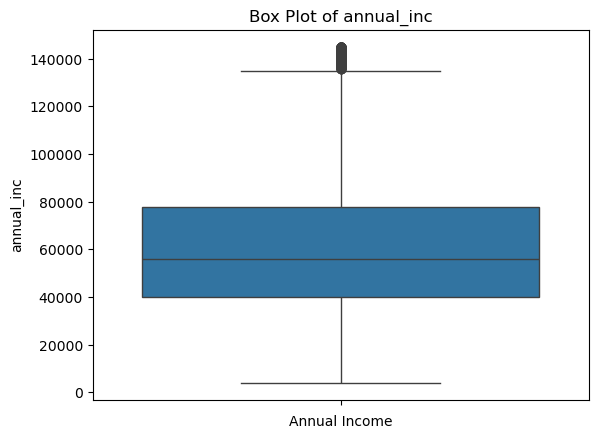

In [24]:
Q1 = df.annual_inc.quantile(0.25)
Q3 = df.annual_inc.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df.annual_inc >= lower_bound) & (df.annual_inc <= upper_bound)]


plt.title(f'Box Plot of annual_inc')
plt.xlabel('Annual Income')
sns.boxplot(df.annual_inc)
plt.show()

In [25]:
# Sanity check to ensure that our data has no null values anymore.
df.isnull().sum()

id                      0
loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
addr_state              0
dti                     0
delinq_2yrs             0
earliest_cr_line        0
total_acc               0
pub_rec_bankruptcies    0
dtype: int64

#### Cleaned up dataset


In [26]:
df

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,total_acc,pub_rec_bankruptcies
0,1077501,5000,36,10.65,162.87,B,B2,10.0,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0,1985-01-01,9,0.0
1,1077430,2500,60,15.27,59.83,C,C4,0.0,RENT,30000.0,Verified,2011-12-01,Charged Off,car,GA,1.00,0,1999-04-01,4,0.0
2,1077175,2400,36,15.96,84.33,C,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0,2001-11-01,10,0.0
3,1076863,10000,36,13.49,339.31,C,C1,10.0,RENT,49200.0,Verified,2011-12-01,Fully Paid,other,CA,20.00,0,1996-02-01,37,0.0
5,1075269,5000,36,7.90,156.46,A,A4,3.0,RENT,36000.0,Verified,2011-12-01,Fully Paid,wedding,AZ,11.20,0,2004-11-01,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39711,92402,5000,36,8.70,158.30,B,B1,5.0,MORTGAGE,75000.0,Not Verified,2007-07-01,Fully Paid,credit_card,CO,15.55,0,1994-05-01,29,0.0
39712,92187,2500,36,8.07,78.42,A,A4,4.0,MORTGAGE,110000.0,Not Verified,2007-07-01,Fully Paid,home_improvement,CO,11.33,0,1990-11-01,40,0.0
39713,90665,8500,36,10.28,275.38,C,C1,3.0,RENT,18000.0,Not Verified,2007-07-01,Fully Paid,credit_card,NC,6.40,1,1986-12-01,9,0.0
39714,90395,5000,36,8.07,156.84,A,A4,0.0,MORTGAGE,100000.0,Not Verified,2007-07-01,Fully Paid,debt_consolidation,MA,2.30,0,1998-10-01,20,0.0


## Data Analysis

### Univariate Analysis

The following key variables will be analyzed:
1. Loan Amount (`loan_amnt`)
2. Interest Rate (`int_rate`)
3. Loan Term (`term`)
4. Loan Grade (`grade`)
5. Employment Length (`emp_length`)
6. Home Ownership (`home_ownership`)
7. Annual Income (`annual_inc`)
8. Debt-to-Income Ratio (`dti`)
9. Loan Status (`loan_status`)
10. Issue Date (`issue_d`) 
11. Issue Date Year (`issue_d_year`)
12. Issue Date Month (`issue_d_month`)


In [93]:
sns.set_style("whitegrid") # Delete this

#### Univariate Analysis: `issue_d`

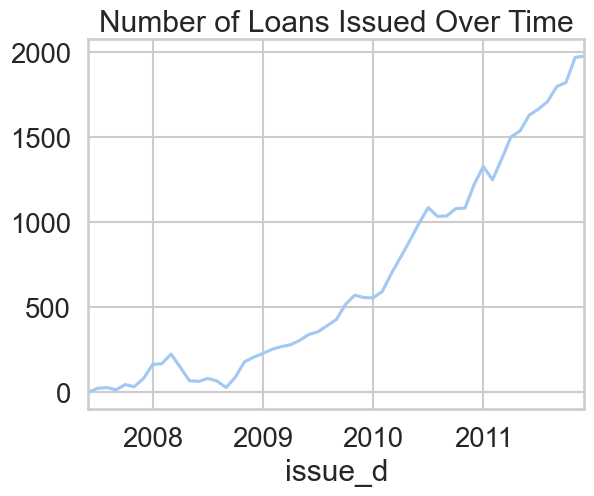

<Figure size 1000x600 with 0 Axes>

In [94]:
# Plotting a trend line to show how number of loans over time
loans_over_time = df.groupby(df['issue_d'].dt.to_period('M')).size()
loans_over_time.plot()
plt.title('Number of Loans Issued Over Time')

plt.figure(figsize=(10,6))
plt.show()

Looking at the figure, we can tell that the number of loans issued over time increased almost exponentially from 2007 to 2011. This could suggest that the Lending Club business is expanding, and thus presents a greater need to be cautious about who loans are being issued to.

#### Univariate Analysis: `issue_d_month`

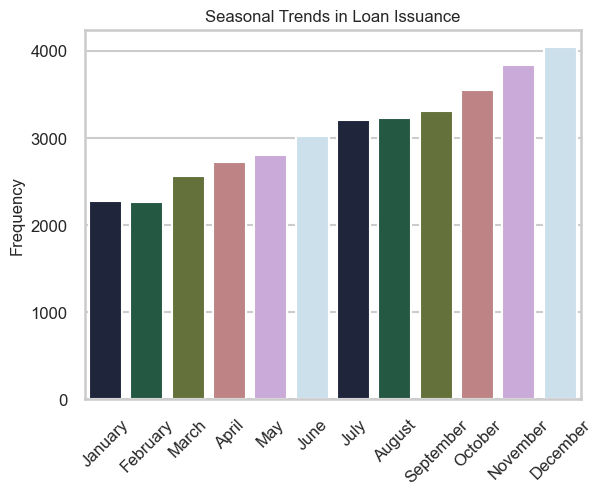

In [102]:
import calendar


df['issue_d_month'] = df['issue_d'].dt.month
seasonal_trends = df.groupby('issue_d_month').size()

# Map month numbers to names
month_names = [calendar.month_name[i] for i in range(1, 13)]
# Ensure the index is sorted to match the month_names order
seasonal_trends = seasonal_trends.reindex(range(1, 13))

# Plotting
sns.barplot(x=month_names, y=seasonal_trends.values, palette=sns.color_palette("cubehelix"))
plt.title('Seasonal Trends in Loan Issuance', fontdict={"fontsize": 12})
plt.ylabel("Frequency", fontdict={"fontsize": 12})
plt.xticks(rotation=45, fontsize=12)  # Rotate xticks by 45 degrees
plt.yticks(fontsize=12)
plt.show()

From the above plot, we can infer that the number of loans steadily increases towards the end of the month. This could be as people are gearing up for holiday season, or could also be because people usually like to make bigger purchases at the start of a new year.

#### Univarite analysis on numerical variables (`loan_amnt`, `int_rate`, `annual_inc`, `dti`)

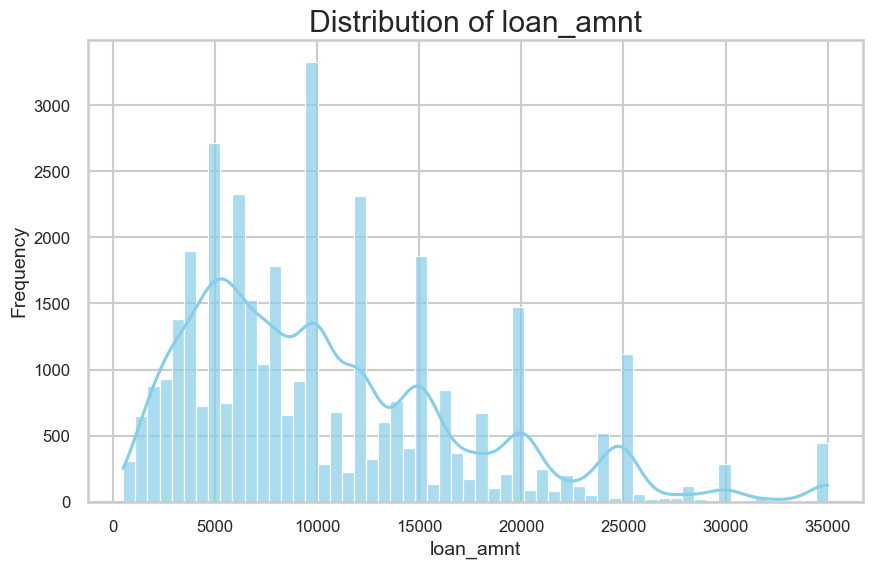

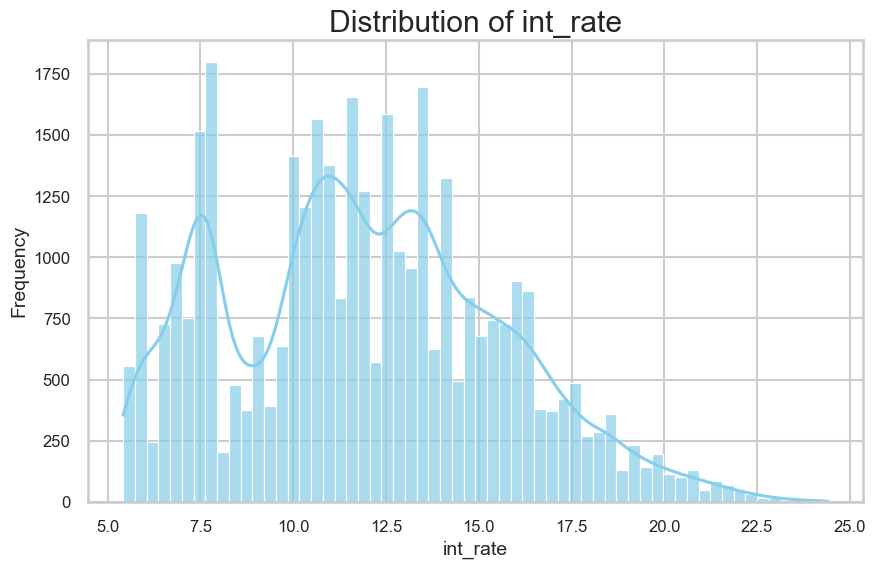

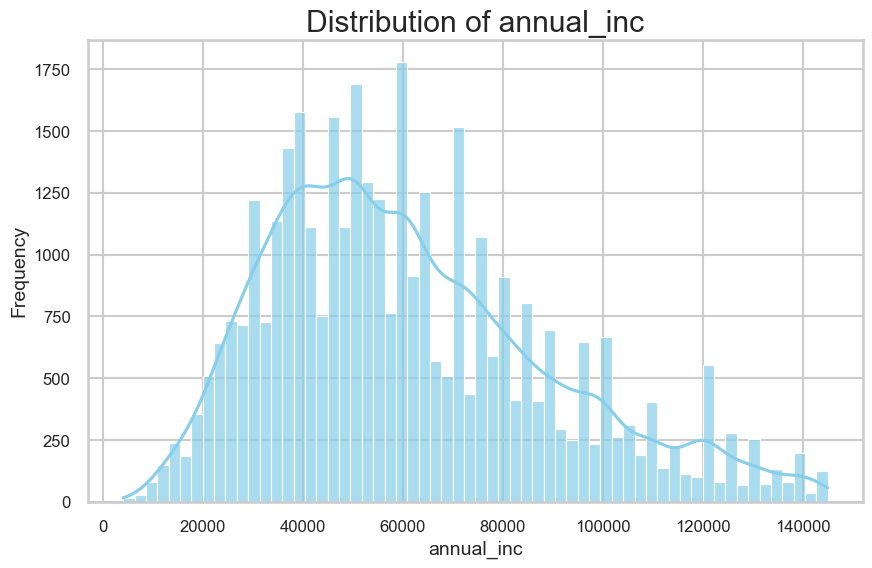

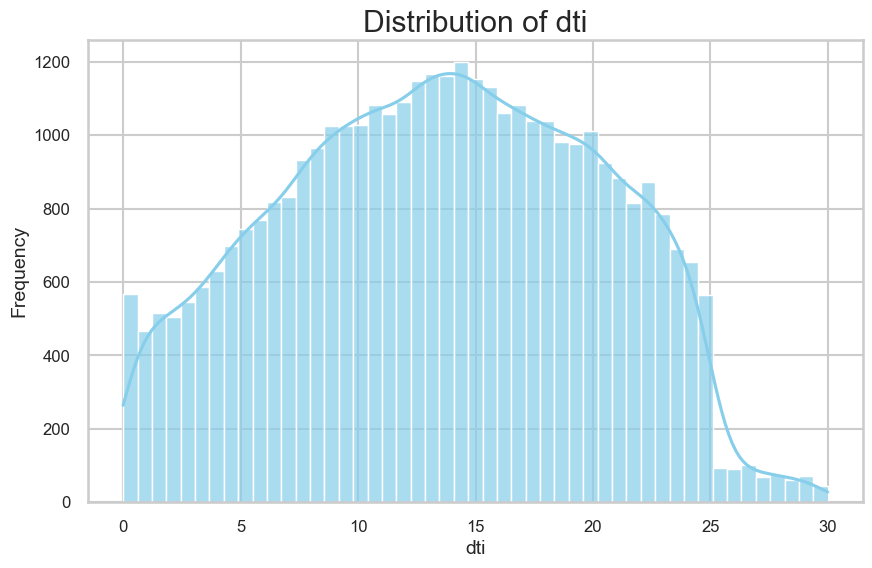

In [111]:
numerical_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']
for var in numerical_vars:
  plt.figure(figsize=(10,6))
  sns.histplot(df[var], kde=True, color="skyblue", alpha=0.7)
  plt.title(f'Distribution of {var}')
  plt.xlabel(var, fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.show()

In [115]:
df.dti.describe()

count    36815.000000
mean        13.437614
std          6.660651
min          0.000000
25%          8.340000
50%         13.570000
75%         18.700000
max         29.990000
Name: dti, dtype: float64

In [121]:
df.int_rate.describe()

count    36815.000000
mean        11.889882
std          3.668709
min          5.420000
25%          8.940000
50%         11.710000
75%         14.270000
max         24.400000
Name: int_rate, dtype: float64

From the above graphs, we can conclude that:
1. **Loan Amount**: Most loans are between 0-10,000$, however, there are also some loans that are higher in amounts, and might indicate a higher risk if not managed properly. We also notice spikes in amounts that are multiples of 5000, as most people probably like to round of how much money they are borrowing in increments of 5000.
2. **DTI**: Ideally, a debt-to-income (DTI) ratio below 36% is deemed favorable and indicative of financial health. The majority of DTI ratios observed fall within a commendable interquartile range (IQR) of 8.3% to 18.7%. This suggests that the borrowers are generally opting for loans that are financially manageable and unlikely to pose repayment challenges.
3. **Interest Rates**: The mean interest rate is 11.8%, where as the highest interest rate is 24.4%. This is a very high interest rate and could indicate that some of the borrowers have bad credit scores and are taking risky loans. It could also be related to the Loan amount, as the graphs follow similar patters. Higher loan amounts result in higher interest rates.

#### Univariate analysis on categorical variables (`term`, `grade`, `emp_length`, `home_ownership`, `loan_status`)

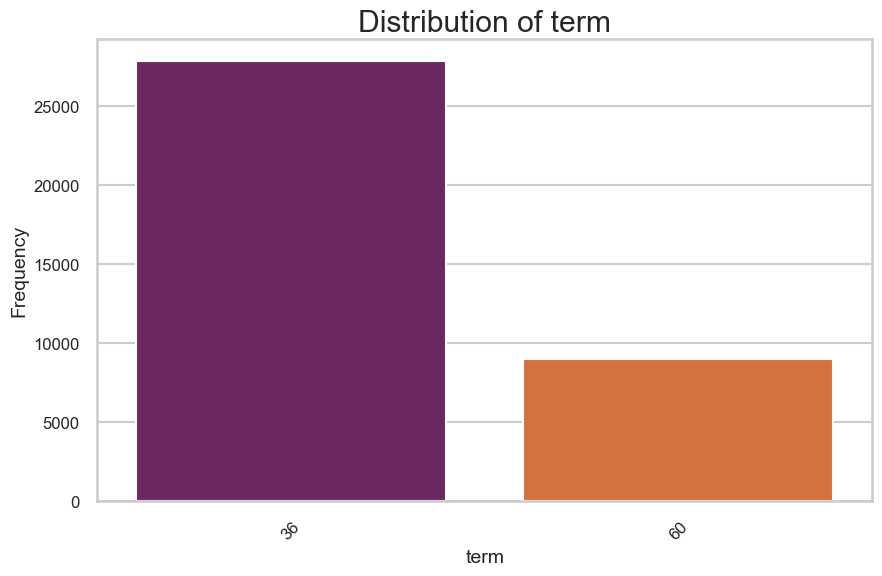

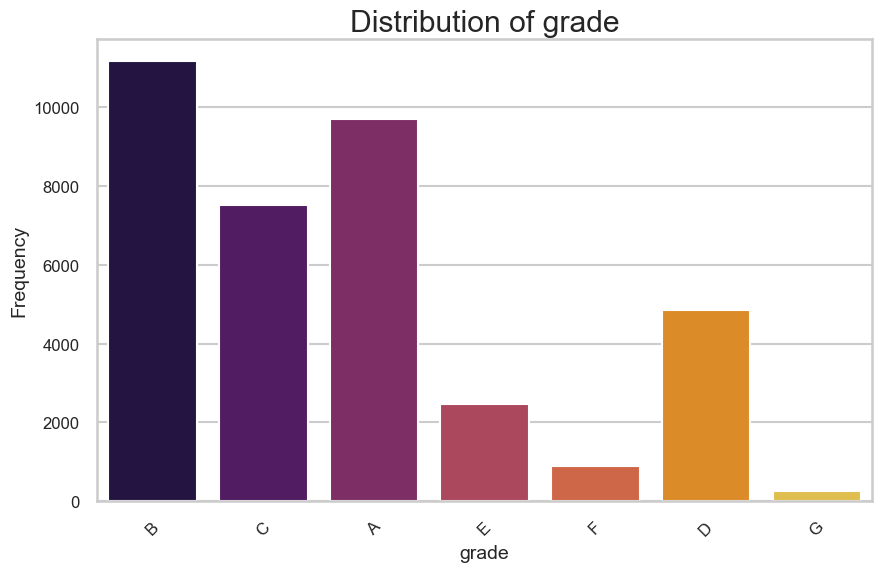

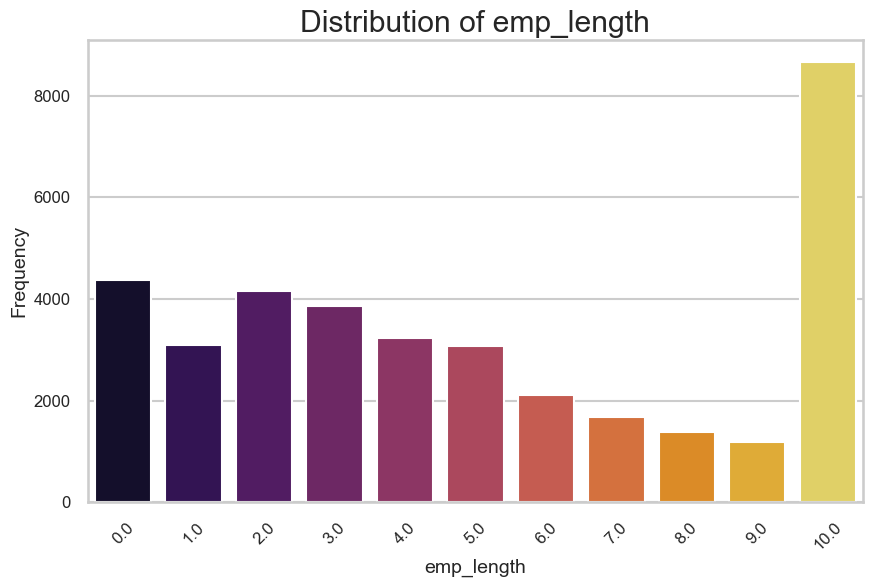

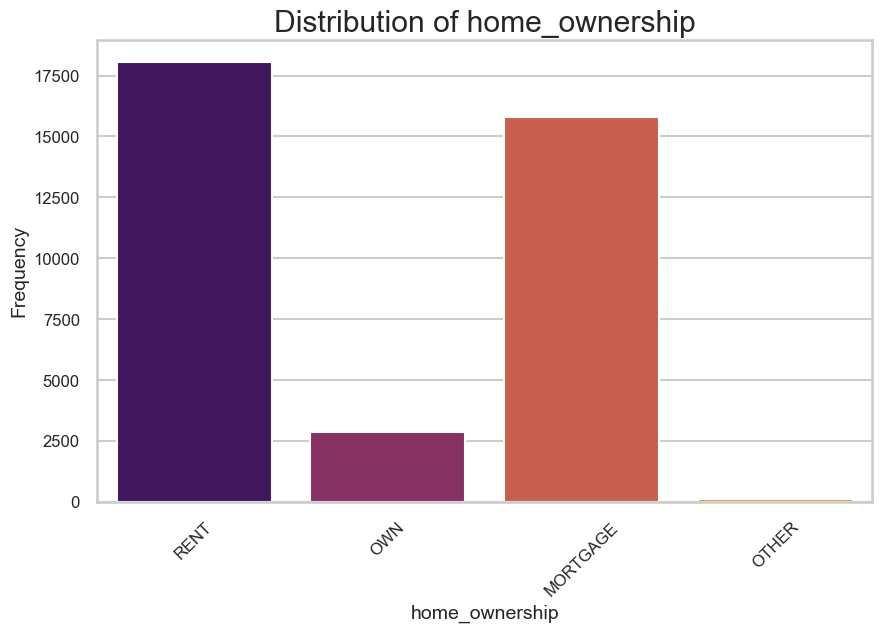

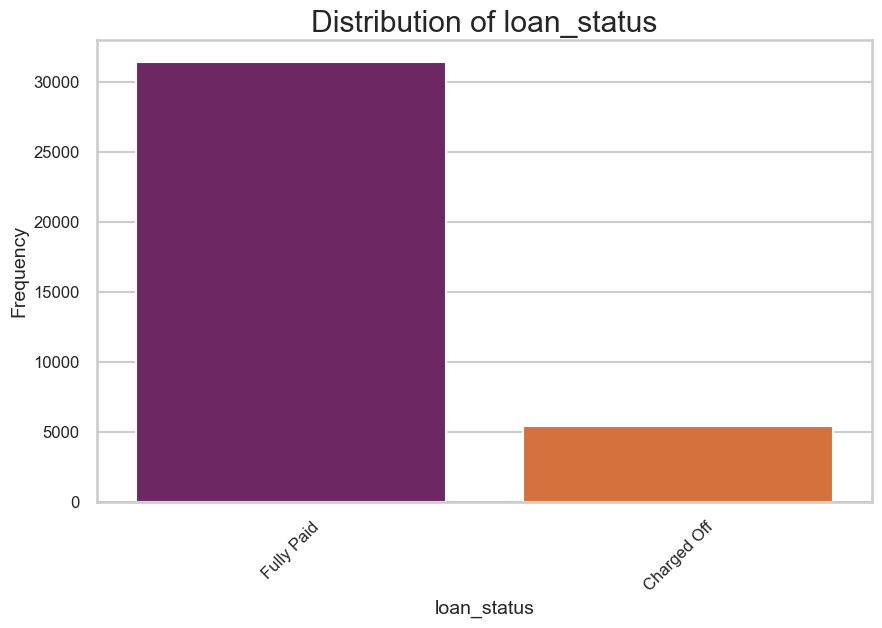

In [132]:
categorical_vars = ['term', 'grade', 'emp_length', 'home_ownership', 'loan_status']
for var in categorical_vars:
    plt.figure(figsize=(10,6))
    sns.countplot(x=var, data=df, palette='inferno')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

From the above graphs we can conclude that:
1. **Grade**: Although most loans are between grades of A, B and C, there are a substantial number of grade D and below that could have higher default rates
2. **Loan Duration**: Although most loans are of 36 months, there a significant number of long term (60 month) loans, these could be riskier compared to short term ones. 
3. **Home Ownership**: Renters could potentially have higher default rates as compared to owners. Further, owners also have a higher collateral, and could get better loans with lower interest rates.
4. **Employment Length**: Borrowers who have been working for a lesser period of time could be associated with higher default rates as compared to those who have been working for longer. We see that people who have been working 10 or more years correspond to a majority of our borrowers.


### Bivariate Analysis

The following bivariate analysis will be considered:
1. Grade vs Loan Status (`grade` vs `loan_status`)
2. Loan Amount vs Loan Status (`loan_amnt` vs `loan_status`)
3. Home Ownership vs Loan Status (`home_ownership` vs `loan_status`)
4. Annual Income vs Loan Status (`annual_inc` vs `loan_status`)
5. DTI vs Loan Status (`dti` vs `loan_status`)
6. Address State vs Loan Status (`addr_state` vs `loan_status`)

In [156]:
# Creating a new columns "loan_default" which maps the loan status to 1 or 0
df['loan_default'] = df['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})

# Numerical variables to analyze
numerical_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']


#### Bivariate Analysis of Quantitative Variables 


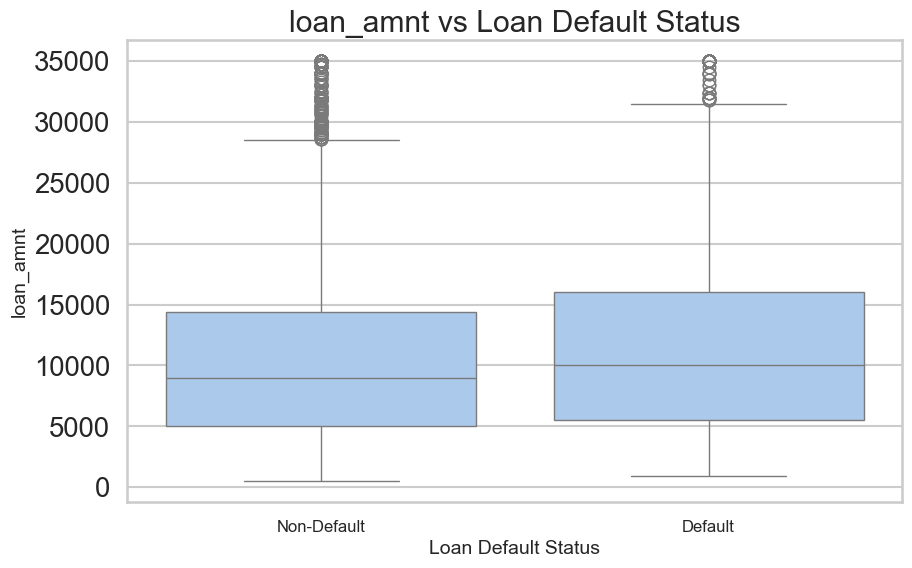

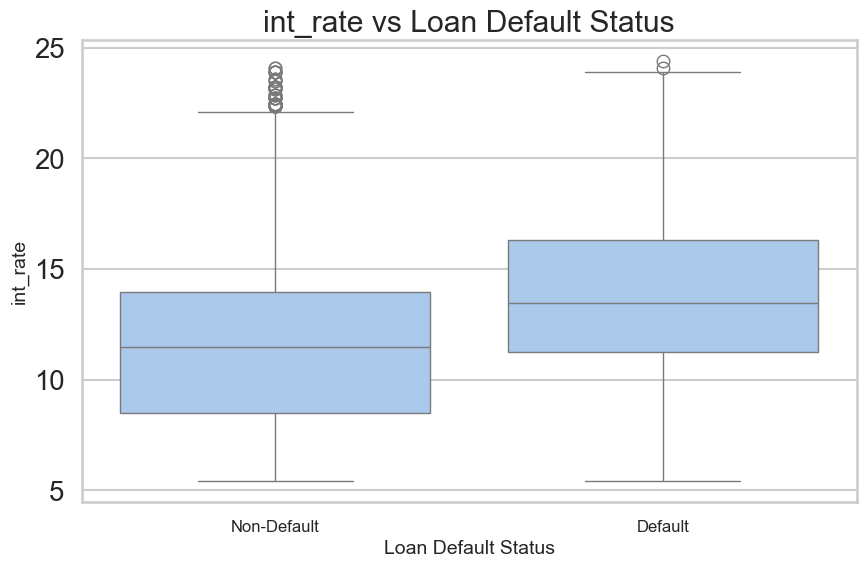

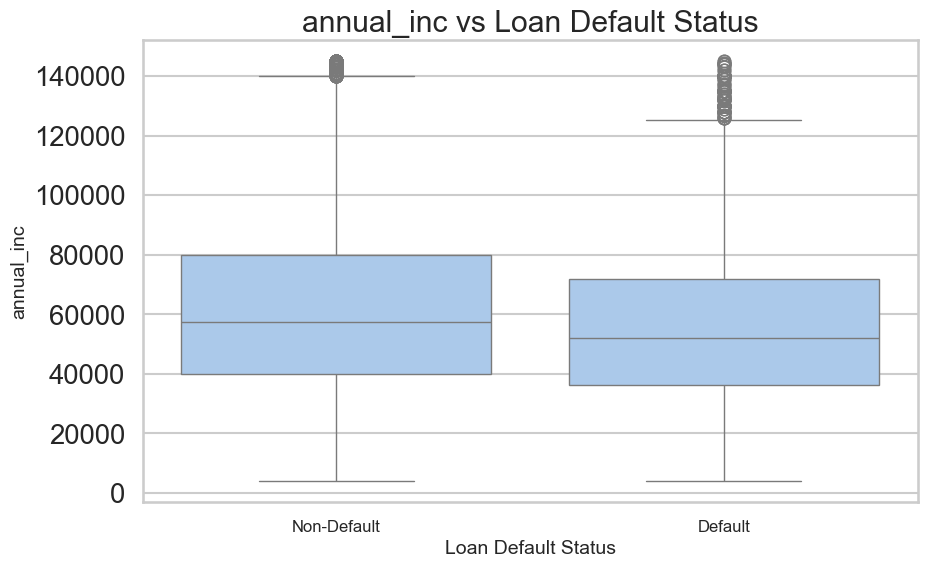

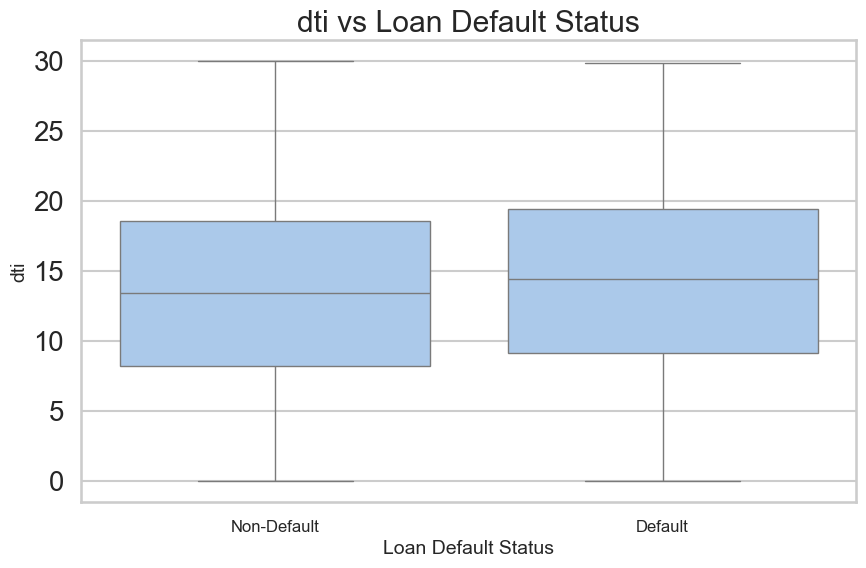

In [159]:
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loan_default', y=var, data=df)
    plt.title(f'{var} vs Loan Default Status')
    plt.xlabel('Loan Default Status', fontsize=14)
    plt.ylabel(var, fontsize=14)
    plt.xticks([0, 1], ['Non-Default', 'Default'], fontsize=12)
    plt.show()

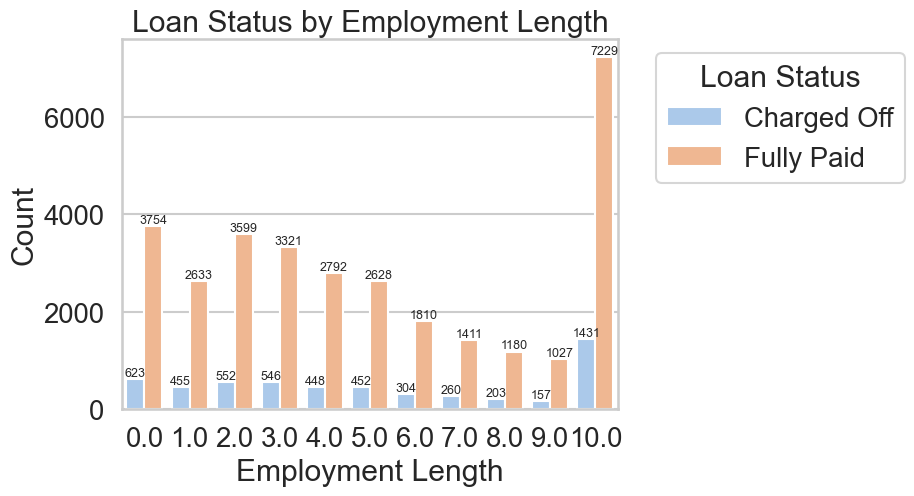

<Figure size 1000x600 with 0 Axes>

In [177]:
ax = sns.countplot(df, x='emp_length', hue='loan_status')
for container in ax.containers:
    ax.bar_label(container, fontsize=9)
plt.title('Loan Status by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(10,6))
plt.show()

#### Bivariate Analysis of Categorical Variables

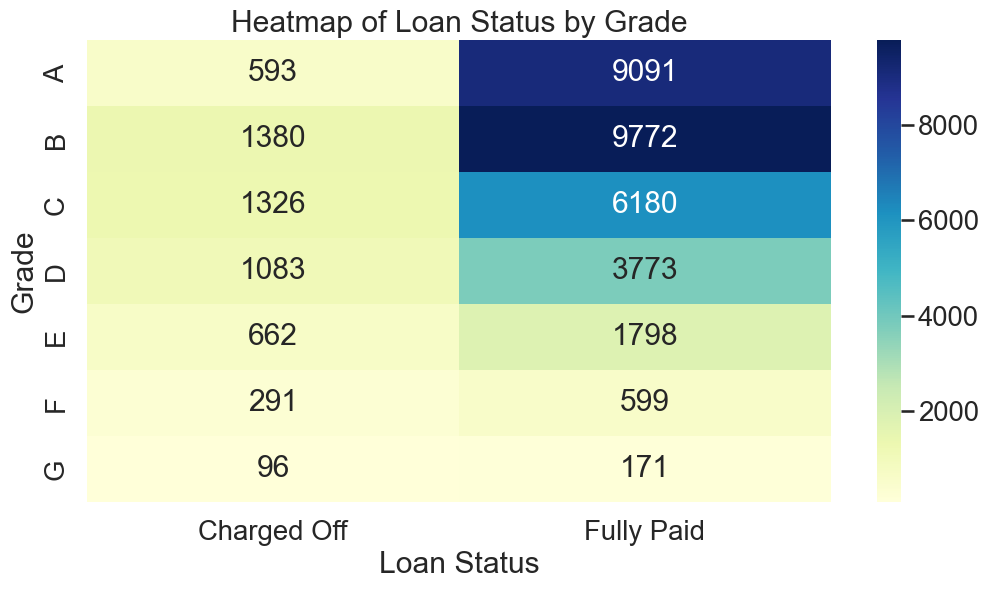

In [149]:
# Create a crosstab of grade and loan status
crosstab = pd.crosstab(df['grade'], df['loan_status'])

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Loan Status by Grade')
plt.xlabel('Loan Status')
plt.ylabel('Grade')
plt.show()

In [167]:
df.columns

Index(['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'total_acc',
       'pub_rec_bankruptcies', 'issue_month', 'issue_d_month', 'issue_d_year',
       'loan_default'],
      dtype='object')

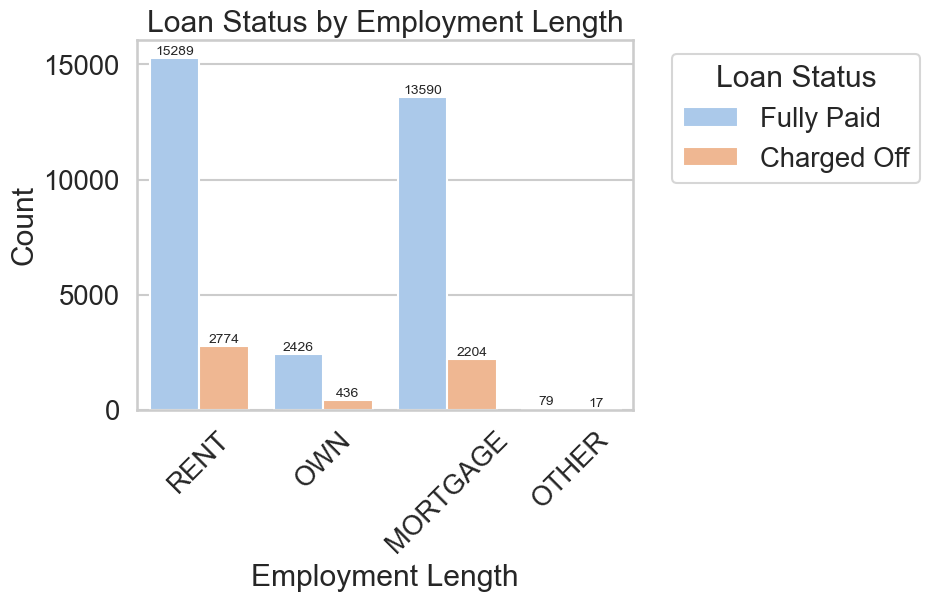

<Figure size 1000x600 with 0 Axes>

In [175]:
ax = sns.countplot(df, x='home_ownership', hue='loan_status')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)
plt.title('Loan Status by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(10,6))
plt.show()

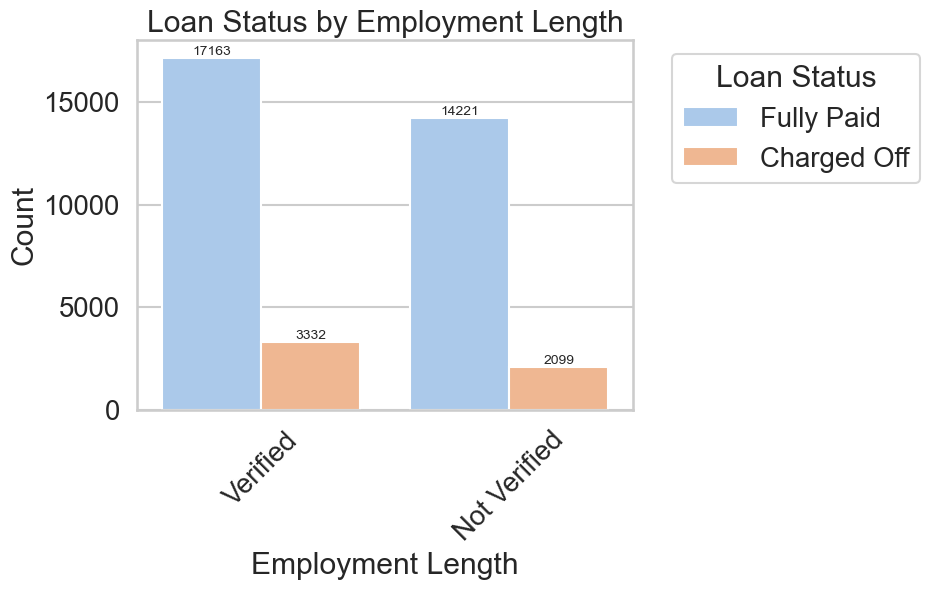

<Figure size 1000x600 with 0 Axes>

In [182]:
ax = sns.countplot(df, x='verification_status', hue='loan_status')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)
plt.title('Loan Status by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(10,6))
plt.show()

In [155]:
# Calculate default rate by state
default_rate_by_state = df[df['loan_status'] == 'Charged Off'].groupby('addr_state').size() / df.groupby('addr_state').size()
default_rate_by_state = default_rate_by_state.reset_index()
default_rate_by_state.columns = ['state', 'default_rate']

# Geographical plot of default rate by state
fig = px.choropleth(default_rate_by_state, 
                    locations='state', 
                    locationmode='USA-states', 
                    color='default_rate', 
                    scope='usa', 
                    title='Default Rate by State'
                  )
fig.show()